# Fibromyalgia Survey - End-to-End Data Pipeline & Dashboard

Fibromyalgia is a highly symptomatic condition and is believed to afflict somewhere between 2-5% of people worldwide. While its etiology is unknown, researchers suspect that fibromyalgia is caused by a dysfunctional nervous system. It is often incorrectly described as an autoimmune disease, as it sometimes presents alongside illnesses like Lupus and Multiple Sclerosis, which are both autoimmune conditions. 

This project shows how patient survey data from a service like Jotform can be wrangled for downstream reporting and analysis using tools like Python and SQL. Note that all data used is synthetic and does not capture clinical findings or observations about fibromyalgia. The steps in the ETL process are as follows:

1) Extract survey data from Jotform using its API
2) Clean and transform the data using Python
3) Load the transformed data into a relational database (I used MS SQL)
4) Use Windows Task Scheduler (or a similar tool like Cron) to run the job ETL daily. A more sophisticated pipeline would require an orchestration tool like Airflow, but such complexity is not warranted here
4) Query the data using a BI tool (I used Power BI) to build a dashboard
5) Embed the dashboard in a web application (I stuck with Power BI's default workspace)

<b/> The survey can be accessed using this link: https://www.jotform.com/232247245750050

<b/> The dashboard can be accessed using this link: https://app.powerbi.com/view?r=eyJrIjoiYTVlMDgyNzAtYzhiZC00NmNiLWE1MGUtZDdjZjIzMzkzNzMzIiwidCI6ImQ5MGRjZTA1LTA2M2QtNDE0Zi1hZWZlLWMyOTJmZjE4ZDhiMCJ9

The dashboard includes a filter (slicer) for biological sex, which can be used to retrieve information about male and female cases specifically. In a production setting, other filters like "Age Range" would be necessary.

# Dashboard Sample

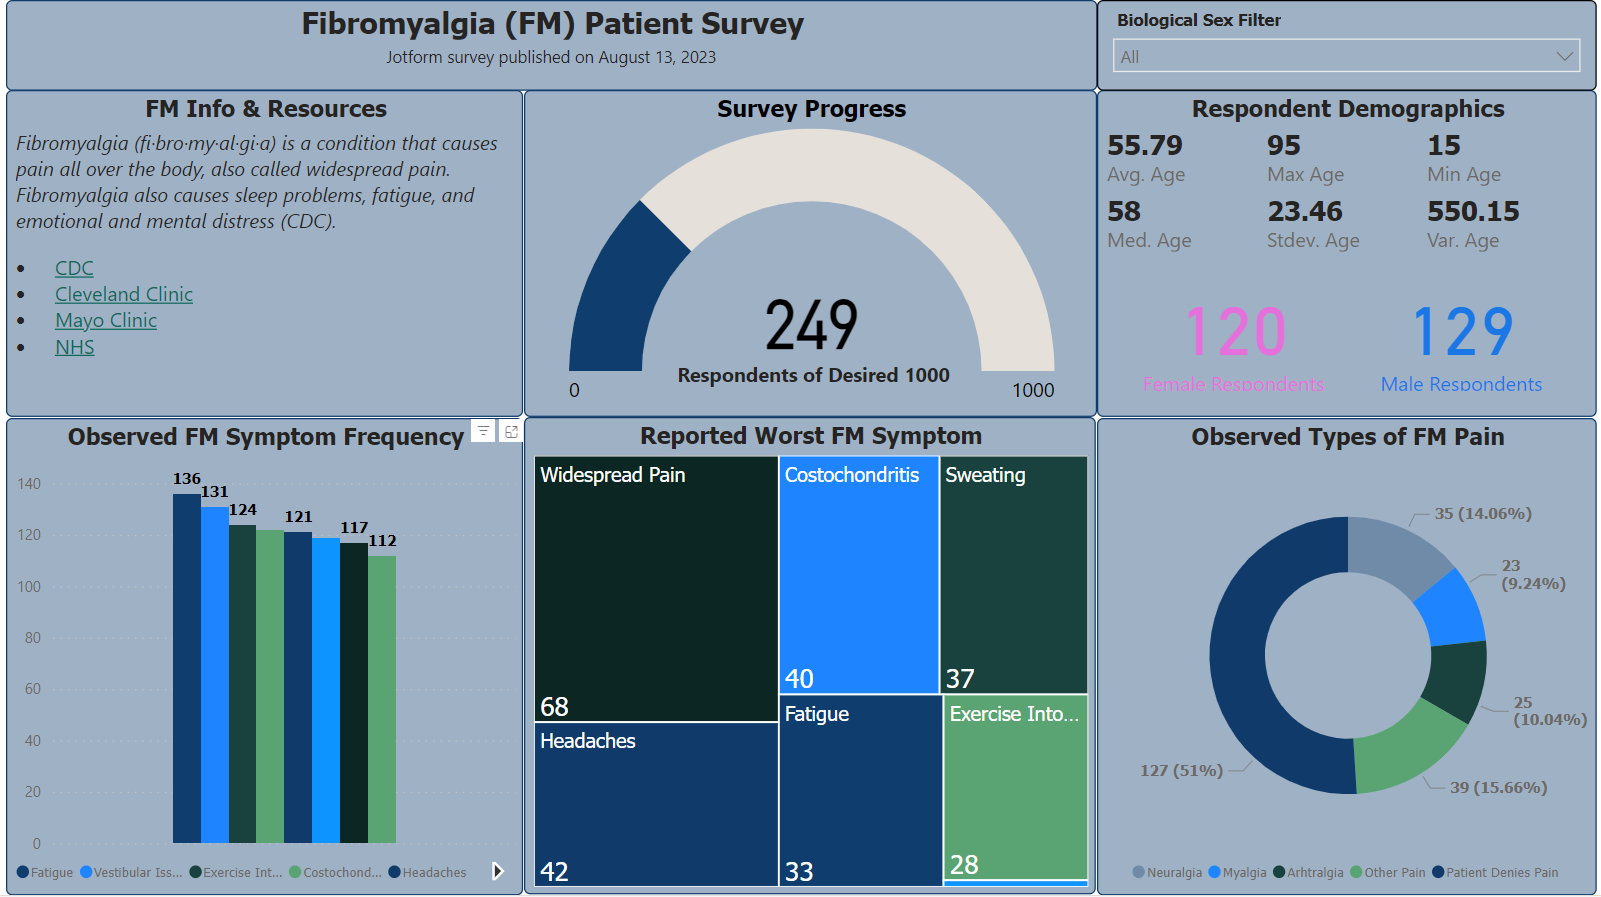

# Data Architecture Diagram

The data flow for this pipeline is shown below. Data is collected by the survey form and is then extracted using Python via the Jotform API. The data is then transformed in Python using Pandas and a little Numpy. Once the data is fully transformed, records are loaded into the MS SQL database, where they can be queried using Power BI or another BI tool.


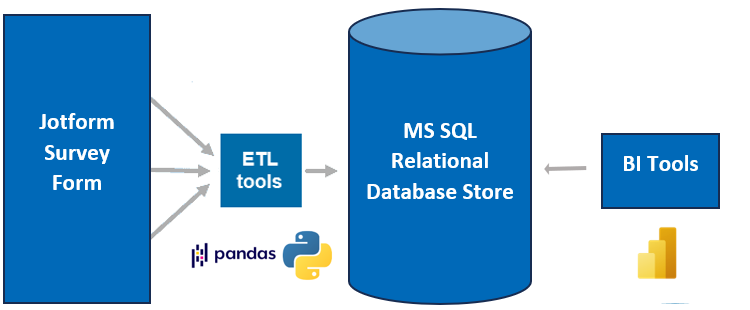

# Job Scheduling

The ETL script was scheduled to run daily using Windows Task Scheduler. In a production setting, a tool like Airflow would be my choice, but because this project involves a single script without dependencies, Task Scheduler is a reasonable option. 

Each time the script runs, the relational database is updated with new records from the Jotform survey. Further, Power BI is using "direct query" mode, so the dashboard is automatically updated nightly when the database is updated.

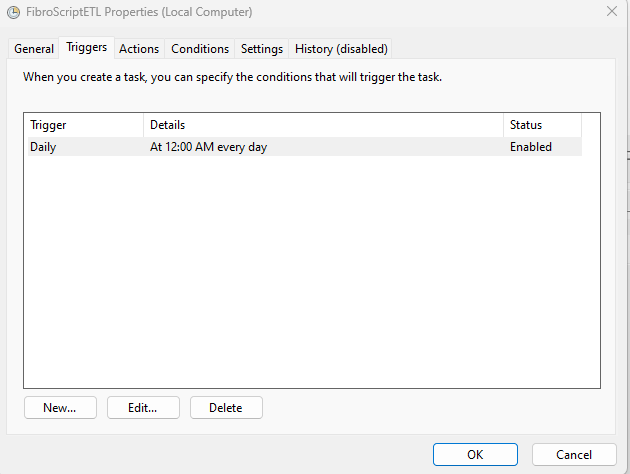

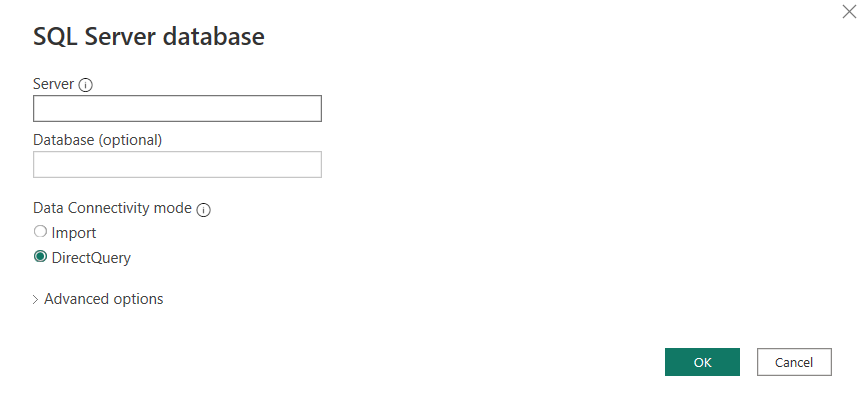

# Common Symptoms of Fibromyalgia

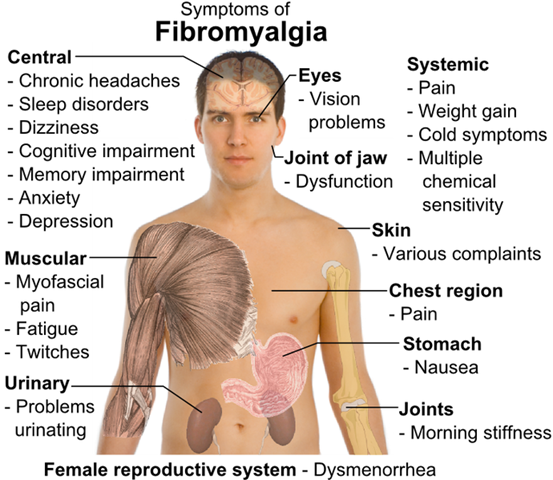

Image Source: https://www.carecochin.com/condition/fibromyalgia

# Final Comments

The remainder of the notebook contains the source code used to implement the data pipeline.

In [36]:
# Import libs
import pandas as pd
import numpy as np
import requests
import json
import pyodbc
import sqlalchemy as db

In [40]:
# Retrieving data from API
response=requests.get(url)
parsed_data=json.loads(response.text)
submissions=parsed_data['content']

In [42]:
# Create df from submissions
df_raw=pd.json_normalize(submissions)
df_raw=df_raw[df_raw['status']!='DELETED']

In [43]:
# Most cols in df_cols map nicely to useful data elements
# answers.3.answer needs to be transformed into dummies, so split into two df's

In [44]:
# Select specific cols
df_main=df_raw.loc[:, ["id", "created_at", "answers.4.answer", "answers.5.answer", 
                       "answers.6.answer", "answers.7.answer"]]

# Rename cols
df_main=df_main.rename(columns={"id":"Response_ID", "created_at":"Submission_Datetime", "answers.4.answer":"Worst_Symptom",
                                "answers.5.answer":"Biological_Sex", "answers.6.answer":"Age", "answers.7.answer":"Pain_Type"})

df_main.head()

,Response_ID,Submission_Datetime,Worst_Symptom,Biological_Sex,Age,Pain_Type
0,5684813247319989686,2023-08-21 22:42:04,Headaches,Female,19,Some Other Sensation
1,5684417947319499490,2023-08-21 11:43:14,Fatigue,Female,73,Myalgia (i.e. muscle pain)
2,5683547497311445561,2023-08-20 11:32:29,Muscle Twitching,Male,22,I do not experience fibromyalgia pain
3,5683130647317933375,2023-08-19 23:57:44,Widespread Pain,Male,29,"Neuropathic Pain (e.g., burning, tingling, sho..."
4,5683032067317390414,2023-08-19 21:13:26,Headaches,Female,67,"Neuropathic Pain (e.g., burning, tingling, sho..."


In [45]:
# https://www.includehelp.com/python/pandas-convert-a-column-of-list-to-dummies.aspx#:~:text=To%20get%20a%20dummy%20column,on%20both%20rows%20%26%20column%20values.
df_q3=pd.get_dummies(df_raw['answers.3.answer'].apply(pd.Series).stack()).groupby(level=0).sum()
df_q3=df_q3.add_suffix('_YN')
df_q3=df_q3.rename(columns={"Excessive Sweating_YN":"Excessive_Sweating_YN",
                            "Exercise Intolerance_YN":"Exercise_Intolerance_YN",
                            "Muscle Twitching_YN":"Muscle_Twitching_YN",
                            "Vestibular & Balance Issues_YN":"Vestibular_Issues_YN",
                            "Widespread Pain_YN":"Pain_YN"})
df_q3.head()

,Costochondritis_YN,Excessive_Sweating_YN,Exercise_Intolerance_YN,Fatigue_YN,Headaches_YN,Muscle_Twitching_YN,Vestibular_Issues_YN,Pain_YN
0,0,0,1,0,1,0,1,1
1,0,0,0,1,1,0,1,1
2,0,0,0,0,1,1,1,0
3,1,1,1,0,1,1,1,1
4,0,0,0,0,1,0,1,1


In [46]:
# Join df's back together on index
df_clean=df_main.join(df_q3, how='inner')
df_clean.head()

,Response_ID,Submission_Datetime,Worst_Symptom,Biological_Sex,Age,Pain_Type,Costochondritis_YN,Excessive_Sweating_YN,Exercise_Intolerance_YN,Fatigue_YN,Headaches_YN,Muscle_Twitching_YN,Vestibular_Issues_YN,Pain_YN
0,5684813247319989686,2023-08-21 22:42:04,Headaches,Female,19,Some Other Sensation,0,0,1,0,1,0,1,1
1,5684417947319499490,2023-08-21 11:43:14,Fatigue,Female,73,Myalgia (i.e. muscle pain),0,0,0,1,1,0,1,1
2,5683547497311445561,2023-08-20 11:32:29,Muscle Twitching,Male,22,I do not experience fibromyalgia pain,0,0,0,0,1,1,1,0
3,5683130647317933375,2023-08-19 23:57:44,Widespread Pain,Male,29,"Neuropathic Pain (e.g., burning, tingling, sho...",1,1,1,0,1,1,1,1
4,5683032067317390414,2023-08-19 21:13:26,Headaches,Female,67,"Neuropathic Pain (e.g., burning, tingling, sho...",0,0,0,0,1,0,1,1


In [47]:
# Simplify pain_type col with np.select
conditions=[df_clean['Pain_Type']=='Myalgia (i.e. muscle pain)', df_clean['Pain_Type']=='Joint Pain', 
            df_clean['Pain_Type']=='Some Other Sensation', 
            df_clean['Pain_Type']=='Neuropathic Pain (e.g., burning, tingling, shock-like sensations, etc.)', 
            df_clean['Pain_Type']=='I do not experience fibromyalgia pain']
replacements=['Myalgia', 'Arthralgia', 'Other', 'Neuralgia', 'No Pain']
df_clean['Pain_Type']=np.select(conditions, replacements)
df_clean.head()

,Response_ID,Submission_Datetime,Worst_Symptom,Biological_Sex,Age,Pain_Type,Costochondritis_YN,Excessive_Sweating_YN,Exercise_Intolerance_YN,Fatigue_YN,Headaches_YN,Muscle_Twitching_YN,Vestibular_Issues_YN,Pain_YN
0,5684813247319989686,2023-08-21 22:42:04,Headaches,Female,19,Other,0,0,1,0,1,0,1,1
1,5684417947319499490,2023-08-21 11:43:14,Fatigue,Female,73,Myalgia,0,0,0,1,1,0,1,1
2,5683547497311445561,2023-08-20 11:32:29,Muscle Twitching,Male,22,No Pain,0,0,0,0,1,1,1,0
3,5683130647317933375,2023-08-19 23:57:44,Widespread Pain,Male,29,Neuralgia,1,1,1,0,1,1,1,1
4,5683032067317390414,2023-08-19 21:13:26,Headaches,Female,67,Neuralgia,0,0,0,0,1,0,1,1


In [48]:
# Data quality assumptions

# Age should be a positive integer
# If not, replace with median of other ages
df_clean['Age']=df_clean['Age'].astype(float)
df_clean['Age']=np.where(df_clean['Age'] < 0, np.median(df_clean['Age']), df_clean['Age'])

In [49]:
# A patient with pain_YN=0 should have a pain type of no pain
#df_clean['Pain_Type']=df_clean['Age'].astype(str).astype(int)
df_clean['Pain_Type']=np.where(df_clean['Pain_YN']==0, "No Pain", df_clean['Pain_Type'])
df_clean.head()

,Response_ID,Submission_Datetime,Worst_Symptom,Biological_Sex,Age,Pain_Type,Costochondritis_YN,Excessive_Sweating_YN,Exercise_Intolerance_YN,Fatigue_YN,Headaches_YN,Muscle_Twitching_YN,Vestibular_Issues_YN,Pain_YN
0,5684813247319989686,2023-08-21 22:42:04,Headaches,Female,19.0,Other,0,0,1,0,1,0,1,1
1,5684417947319499490,2023-08-21 11:43:14,Fatigue,Female,73.0,Myalgia,0,0,0,1,1,0,1,1
2,5683547497311445561,2023-08-20 11:32:29,Muscle Twitching,Male,22.0,No Pain,0,0,0,0,1,1,1,0
3,5683130647317933375,2023-08-19 23:57:44,Widespread Pain,Male,29.0,Neuralgia,1,1,1,0,1,1,1,1
4,5683032067317390414,2023-08-19 21:13:26,Headaches,Female,67.0,Neuralgia,0,0,0,0,1,0,1,1


In [50]:
# Unit Testing - Data Quality Checks

# Assert that all age values are positive
for i in df_clean['Age']:
    assert (i > 0)
    
# Assert that if pain=0, then pain_type=no_pain
for i in df_clean[['Pain_Type', 'Pain_YN']].values:
    assert((i[0] in ['Neuralgia', 'Myalgia', 'Arthralgia', 'Other'] and i[1]==1) or (i[0]=='No Pain' and i[1]==0))

In [51]:
# Since this is a tiny dataset, we can just read everything in the DB to determine which records are new and require loading
# To scale this up, we could add a "last_updated" timestamp to all records, and only load in those whose timestamp is after
# the most recent ETL job

# Connect to db
engine=db.create_engine(con)

# Query survey_results
df_exclude=pd.read_sql('SELECT * FROM survey_results', engine)

# Exclusion list
exclude=list(df_exclude['Response_ID'])

# Existing list
all_records=list(df_clean['Response_ID'])

# Inclusion List
include=list(set(all_records) - set(exclude))
include

# Reset index on df_clean
df_clean=df_clean.reset_index()
df_clean=df_clean.drop(['index'], axis=1)

# df_final (only load records not already in DB)
df_clean['Inclusion_Flag']=""
for i in range(0, len(df_clean)):
    if df_clean.iloc[i, 0] in include:
        df_clean.loc[i, "Inclusion_Flag"]='Y'
    else:
        df_clean.loc[i, "Inclusion_Flag"]='N'

In [52]:
# Only include new rows
df_final=df_clean[df_clean['Inclusion_Flag']=='Y']
df_final=df_final.drop(columns='Inclusion_Flag')
df_final.head()

,Response_ID,Submission_Datetime,Worst_Symptom,Biological_Sex,Age,Pain_Type,Costochondritis_YN,Excessive_Sweating_YN,Exercise_Intolerance_YN,Fatigue_YN,Headaches_YN,Muscle_Twitching_YN,Vestibular_Issues_YN,Pain_YN
0,5684813247319989686,2023-08-21 22:42:04,Headaches,Female,19.0,Other,0,0,1,0,1,0,1,1


In [53]:
# Load df_final into SQL Server DB
database='fibro'
cnxn=pyodbc.connect(driver='SQL Server', server=server, database=database)
cursor=cnxn.cursor()

# https://learn.microsoft.com/en-us/sql/machine-learning/data-exploration/python-dataframe-sql-server?view=sql-server-ver16
for index, row in df_final.iterrows():
    cursor.execute('''INSERT INTO survey_results (Response_ID, Submission_Datetime, Biological_Sex, Age, 
                   Worst_Symptom, Pain_Type, Pain_YN, Fatigue_YN, Headaches_YN, Muscle_Twitching_YN, Sweating_YN, 
                   Exercise_Intolerance_YN, Costochondritis_YN,  Vestibular_Issues_YN) 
                   values(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''', 
                   row.Response_ID, row.Submission_Datetime, row.Biological_Sex, row.Age, row.Worst_Symptom,
                   row.Pain_Type, row.Pain_YN, row.Fatigue_YN, row.Headaches_YN, row.Muscle_Twitching_YN,
                   row.Excessive_Sweating_YN, row.Exercise_Intolerance_YN, row.Costochondritis_YN, 
                   row.Vestibular_Issues_YN)

# Commit changes, close cursor
cnxn.commit()
cursor.close()